## Library imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage.morphology import opening
from skimage import filters
from skimage import transform
from functools import partial 
import pandas as pd
from os import listdir
import os
from os import listdir
from os.path import isfile, join
import fyp2021p3_group00_functions as util
import seaborn as sns
import cv2, numpy as np
from sklearn.cluster import KMeans
from matplotlib import rcParams
from PIL import Image
import warnings

# Define functions

In [15]:

# this code append the rgb values into a pandas dataframe
def color_normalizer(arr, name):
    counter = 1
    for (percent, color) in arr:
        c1 = int(color[0])
        c2 = int(color[1])
        c3 = int(color[2])
        index = pics[pics['image_id'] == name].index.values
        rowIndex = pics.index[index]
        rgb_str = str(c1) + "," + str(c2) + "," + str(c3)
        pics.loc[rowIndex, 'colorRGB_'+str(counter)] = rgb_str
        pics.loc[rowIndex, 'occurence_of_colour_percent_'+str(counter)] = percent*100
        counter = counter + 1
    None

# function for most dominant colors
def dominant_colors(cluster, centroids, name):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()
    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    color_normalizer(colors, name) 
    for (percent, color) in colors:
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

# function to rgb color to html color
def clamp(x): 
  return max(0, min(x, 255))

# finding symetry
def find_symmetry(image):
    """
    Finds the symmetry of two halfs of the same image.
    From this post: https://stackoverflow.com/questions/10873824/how-to-convert-2d-float-numpy-array-to-2d-int-numpy-array
    """
    right = image.shape[1] #The width of the image, used to find the middle
    symmetry_list = []
    for angle in range(0,180,10):
        rotated_image = transform.rotate(image, angle) #Rotating the image by a multiple of 10 degrees
        non_flipped, flipped = rotated_image[:,:int(right/2)], np.flip(rotated_image[:,int(right/2):],1) #dividing the image into left and right halves
        dimension_diff = non_flipped.shape[1] - flipped.shape[1]
        non_flipped = rotated_image[:,:int(right/2)-dimension_diff] #done to avoid dimensional comparison errors
        
        non_flipped_int = non_flipped.astype(int) #Typecast to int to allow np.bitwise to work
        flipped_int = flipped.astype(int) #Typecast to int to allow np.bitwise to work
        intersection = np.bitwise_or(non_flipped_int, flipped_int)
        union = np.bitwise_and(non_flipped_int, flipped_int)
        res = np.count_nonzero(intersection) / (np.count_nonzero(union)+1)
        symmetry_list.append(res)
    return(min(symmetry_list))
        
        
def border_overlap(image):
    """
    Marks the border of a lesion, and divides this into left and rigt sub-images through the middle of the image.
    the quotient of non-zero pixels between the two halves of the image overlayed and only the left side is calculated
    and saved in a list. The image is then rotated 10 degrees, and the process is repeated, untill a rotation of 180
    degrees have been made. Returns the minimum quotient stored in the list, and the rotation of the image required
    to make that minimum, stored in degrees.
    """
    struct_el = morphology.disk(10)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    image_perimeter = image-mask_eroded #Making the border of the image only
    right = image_perimeter.shape[1] #The width of the image, used to find the middle
    nonzero_list = []
    for angle in range(0,180,10):
        rotated_image = transform.rotate(image_perimeter, angle) #Rotating the image by a multiple of 10 degrees
        non_flipped, flipped = rotated_image[:,:int(right/2)], np.flip(rotated_image[:,int(right/2):],1) #dividing the image into left and right halves
        dimension_diff = non_flipped.shape[1] - flipped.shape[1] #Finding possible differences in dimensions of the halves
        non_flipped = rotated_image[:,:int(right/2)-dimension_diff] #Done to avoid dimensional comparison errors
        overlap = non_flipped.copy() #Copying one half to ensure that we don't make shallow copies of the original image
        overlap[flipped==1] = 1 #The actual overlay
        flipped_nonzero = np.count_nonzero(flipped) #Calculates non-zero pixels of the right image
        overlap_nonzero = np.count_nonzero(overlap) #Calculates non-zero pixels of the left image
        nonzero_list.append(abs(overlap_nonzero/(flipped_nonzero+1))) #Appends 'non-zero overlap / non-zero+1' left to a list, +1 to avoid division-by-zero
    return(min(nonzero_list),nonzero_list.index(min(nonzero_list))) #Returns the minimum of the nonzero list after the image has been rotated 180 degrees


def make_border_symmetry_csv(filepath):
    """
    Function that takes image names from a filepath and returns the 'image_id' and contents of the 'border-overlap'
    function to a .csv file called 'border_symmetry' in the data/processed folder.
    """
    unfiltered_images = listdir(filepath) #Get the list of names of everything in the specified directory
    filter_img = [i.strip(".jpg") for i in unfiltered_images if ".jpg" in i] #Make list of only image names
    most_overlap_list = [["image_id", "border_diff", "image_symmetry"]] #list with headers for the csv file
    for i in filter_img: #Loop through list
        image = plt.imread("../data/example_segmentation/sm/"+i+"_segmentation.png") #Load corresponding image segmentation of the image name
        borders = np.where(image!=0) #Find non-zero elements of the image
        up, down = min(borders[0]),max(borders[0]) #min and max height of image
        left, right = min(borders[1]),max(borders[1]) #Min and max width of image
        segment_image = image[up:down,left:right] #'Zoomed-in' image, discarding non-lesion parts of the image
        j, k = border_overlap(segment_image) # Call to func border_overlap
        sym = find_symmetry(segment_image) # Call to func find_symmetry
        most_overlap_list.append([i,j, sym]) #Append image_id, border-quotient and degree-rotation to the list
    np.savetxt("../data/processed/border_symmetry.csv",
        most_overlap_list, delimiter=",", fmt = "% s") #Turn list into .csv file in the data/processed folder
    print('Make_border_symmetry_csv done') #Reassuring message that it went succesfully :)

    

# Read in raw datasets

In [2]:
pics = pd.read_csv("../data/example_ground_truth.csv", sep = ",")
pics_to_process = pd.read_csv("../data/processed/dominant_colors_raw.csv", sep = ",")

# Search the 4 most dominant color of each picture

Loop through a 25% smaller pictures. Code makes a pandas dataframe with 4 - 4 column (RGB code in string than occurance in %)

In [ ]:
WARN = input("This operation takes several minutes, the raw dataset is already exist. Do you wish to continue: (Yes/No) ")

if WARN.lower().startswith("y"):
    print("\n---It takes time --- \n")
    for i in pics["image_id"]:
        #print(i)
        # Alternative: replace the non-lesion pixels
        im = plt.imread('../data/example_image/sm/'+i+'.jpg')
        #plt.imshow(im)
        img2 = im.copy()
        mask=plt.imread('../data/example_segmentation/sm/'+i+'_segmentation.png')
        img2[mask==0] = 0
        #plt.imshow(img2)
        image = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        reshape = img2.reshape((img2.shape[0] * img2.shape[1], 3))
        # Find and display most dominant colors
        cluster = KMeans(n_clusters=5).fit(reshape)
        visualize = dominant_colors(cluster, cluster.cluster_centers_, i)
    display(pics)
    pics.to_csv('../data/processed/dominant_colors_raw.csv')
else:
    print("Cancelled operation")

In [ ]:
# highest element check, also for a good masks
for i in range(len(pics_to_process["image_id"])):
    txt = pics_to_process["colorRGB_5"][i]
    x = txt.split(",")
no_adjsutment_examples_column_5 = ["ISIC_0009995","ISIC_0014688","ISIC_0014712","ISIC_0014937","ISIC_0015062","ISIC_0015256","ISIC_0015372"]

## Delete max values if they are the black areas and adjust the remain 4 dominant colors

Delete max values if they are the black areas and adjust the remain 4 dominant colors. We need this since a masked ares were used which has black as dominant color

In [18]:
for i in range(len(pics_to_process["image_id"])):
    txt = pics_to_process["colorRGB_5"][i]
    x = txt.split(",")
    sumy = 0
    for y in range(len(x)):
        sumy = sumy + int(x[y])
    if sumy > 0:
        None

In [19]:
# rearrange the non-black colours in column 5
no_adjsutment_examples_column_5 = ["ISIC_0009995","ISIC_0014688","ISIC_0014712","ISIC_0014937","ISIC_0015062","ISIC_0015256","ISIC_0015372"]
for i in range(len(pics_to_process["image_id"])):
    pic_id = pics_to_process["image_id"][i]
    if any(t == pic_id for t in no_adjsutment_examples_column_5):
        index = pics_to_process[pics_to_process['image_id'] == pic_id].index.values
        rowIndex = pics_to_process.index[index]
        pics_to_process.loc[rowIndex, 'adjusted_bool'] = 0
    else:
        index = pics_to_process[pics_to_process['image_id'] == pic_id].index.values
        rowIndex = pics_to_process.index[index]
        pics_to_process.loc[rowIndex, 'adjusted_bool'] = 1
        remains = 100 - pics_to_process["occurence_of_colour_percent_5"][i]
        for i in range(1,4+1):
            new_occ_percent = (100/remains)*pics_to_process['occurence_of_colour_percent_'+str(i)]        
            pics_to_process.loc[rowIndex, 'adjusted_percent'+str(1+i)] = new_occ_percent
            None

In [ ]:
# final daztaset about dominant colours
# it gives back lot of errors, bnut still functional
pics_raw = pd.read_csv("../data/processed/dominant_colors_adjusted.csv", sep = ",")
pics_raw.reset_index()
pics_raw["RGB1"] = 0
pics_raw["RGB2"] = 0
pics_raw["RGB3"] = 0
pics_raw["RGB4"] = 0
pics_raw["RGB1_occ"] = 0
pics_raw["RGB2_occ"] = 0
pics_raw["RGB3_occ"] = 0
pics_raw["RGB4_occ"] = 0
for i in range(len(pics_raw["image_id"])):
    if pics_raw["adjusted_bool"][i] == 1:
        t = pics_raw["colorRGB_1"][i]
        pics_raw["RGB1"][i] = t
        pics_raw["RGB2"][i] = pics_raw["colorRGB_2"][i]
        pics_raw["RGB3"][i] = pics_raw["colorRGB_3"][i]
        pics_raw["RGB4"][i] = pics_raw["colorRGB_4"][i]
        pics_raw["RGB1_occ"][i] = pics_raw["adjusted_percent2"][i]
        pics_raw["RGB2_occ"][i] = pics_raw["adjusted_percent3"][i]
        pics_raw["RGB3_occ"][i] = pics_raw["adjusted_percent4"][i]
        pics_raw["RGB4_occ"][i] = pics_raw["adjusted_percent5"][i]
    else:
        pics_raw["RGB1"][i] = pics_raw["colorRGB_2"][i]
        pics_raw["RGB2"][i] = pics_raw["colorRGB_3"][i]
        pics_raw["RGB3"][i] = pics_raw["colorRGB_4"][i]
        pics_raw["RGB4"][i] = pics_raw["colorRGB_5"][i]
        pics_raw["RGB1_occ"][i] = pics_raw["occurence_of_colour_percent_2"][i]
        pics_raw["RGB2_occ"][i] = pics_raw["occurence_of_colour_percent_3"][i]
        pics_raw["RGB3_occ"][i] = pics_raw["occurence_of_colour_percent_4"][i]
        pics_raw["RGB4_occ"][i] = pics_raw["occurence_of_colour_percent_5"][i]
        
pics_raw = pics_raw.drop(['colorRGB_1','colorRGB_2','colorRGB_3','colorRGB_4','colorRGB_5'],axis=1)
pics_raw = pics_raw.drop(['occurence_of_colour_percent_1','occurence_of_colour_percent_2','occurence_of_colour_percent_3','occurence_of_colour_percent_4','occurence_of_colour_percent_5'],axis=1)
pics_raw = pics_raw.drop(['adjusted_percent2','adjusted_percent3','adjusted_percent4','adjusted_percent5'],axis=1)


# convert RGB to html colors
color_list =["RGB1","RGB2","RGB3","RGB4"]
for i in color_list:
    pics_raw[i+"html"] = 0
leng = len(dominant_color)
for y in color_list:
    for i,t in zip(range(leng),dominant_color[y]):
        x = t.split(",")
        c1,c2,c3 = int(x[0]),int(x[1]),int(x[2])
        v = "#{0:02x}{1:02x}{2:02x}".format(clamp(c1), clamp(c2), clamp(c3))
        pics_raw[y+"html"][i] = v
        #print(v)
        
pics_raw["help_int_for_colors"] = 0
for i in range(len(pics_raw)):
    if pics_raw["melanoma"][i] == 1:
        pics_raw["help_int_for_colors"][i] = "melanoma"
    elif pics_raw["seborrheic_keratosis"][i] == 1:
        pics_raw["help_int_for_colors"][i] = "keratosis"
    else:
        pics_raw["help_int_for_colors"][i] = "healthy"

pics_raw.to_csv('../data/example_image/sm')

## Make border_symmetry.csv file, based on state of "make_csv_border" variable

### Set to True to make dataset, otherwise keep as false


In [16]:
# Might take a while to run
make_csv_border = False

if make_csv_border == True:
    make_border_symmetry_csv("../data/example_image/new_dataset/")

## Merge datasets

In [17]:
dominant_color = pd.read_csv("../data/processed/dominant_colors_final_dataset.csv", sep = ",")
a_p = pd.read_csv("../features/features.csv", sep = ",")
border_symmetry = pd.read_csv("../data/processed/border_symmetry.csv", sep = ",")
border_symmetry = border_symmetry.drop(['image_id'],axis=1)
dominant_color = dominant_color.drop(['Unnamed: 0','Unnamed: 0.1','adjusted_bool'],axis=1)
final_df = pd.concat([dominant_color, border_symmetry,a_p], axis=1)
final_df = final_df.drop(['Unnamed: 0.1.1',"id"],axis=1)
final_df.to_csv('../data/processed/final_df.csv')

## A diagram about the most dominant colors per each type of skin-disease

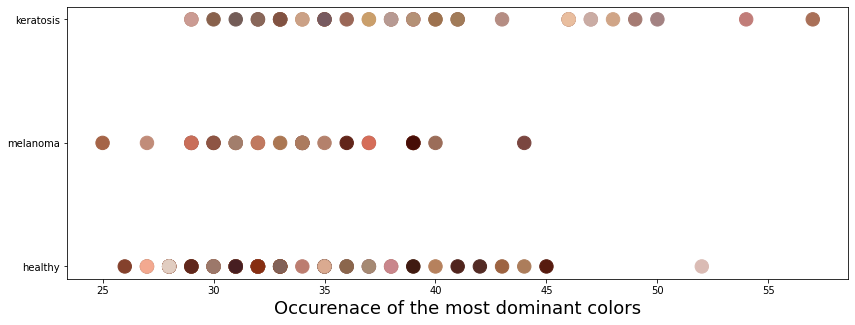

In [5]:
colors=final_df["RGB4html"]
fig, ax = plt.subplots(figsize=(14, 5))
plt.scatter(final_df["RGB4_occ"], 
            final_df["help_int_for_colors"], 
            s=180, 
            c=colors, 
            alpha=1)

#plt.figsize(10,6)
plt.xlabel("Occurenace of the most dominant colors",fontsize=18)
plt.show()

## Area and perimeter scatterplot

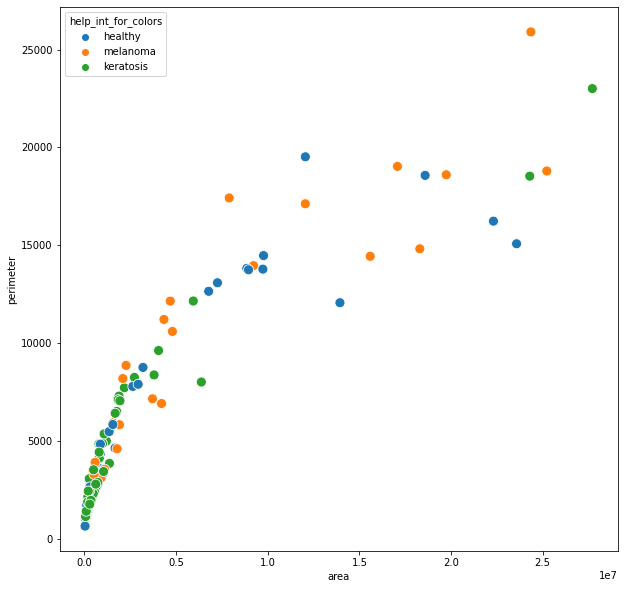

In [20]:
rcParams['figure.figsize'] = 10,10
sns.scatterplot(data=final_df, x="area", y="perimeter", hue="help_int_for_colors", s=100);## A diagram about the most dominant colors per each type of skin-disease

## Pairplot about the daset

Based on the pairplots we couldn't stated any relevant correlation

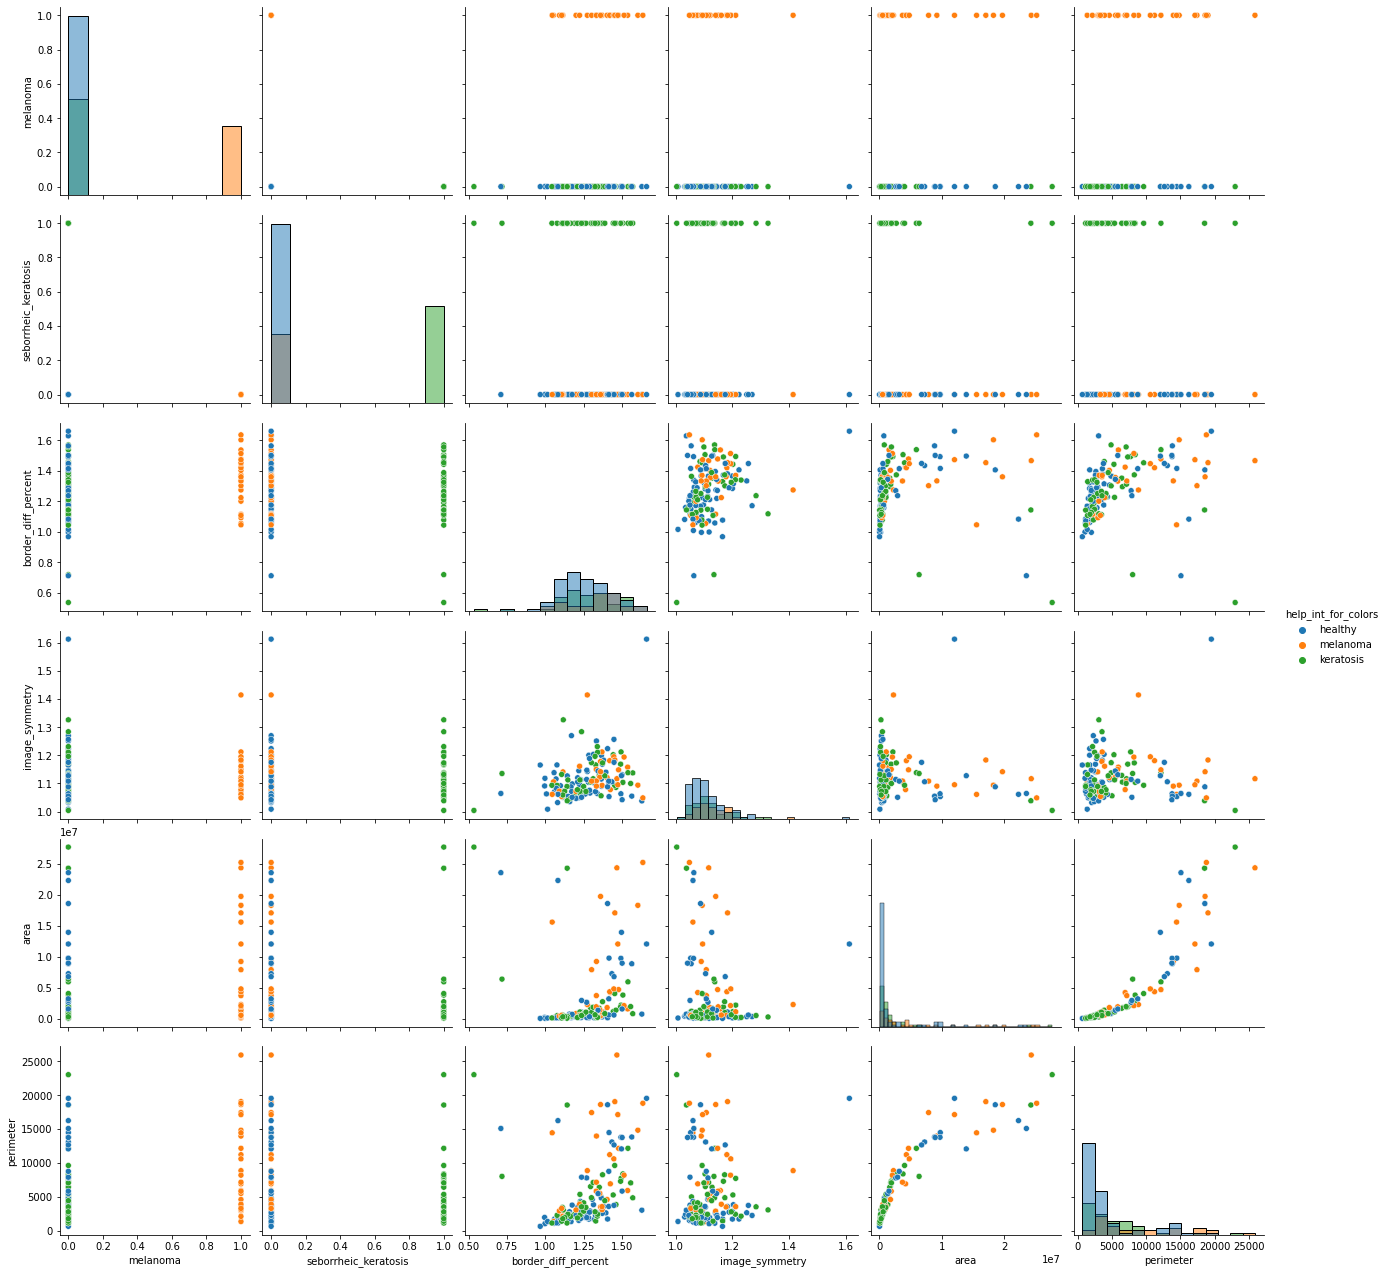

In [7]:
df = final_df.drop(['RGB1','RGB2','RGB3','RGB4','RGB1_occ','RGB2_occ','RGB3_occ','RGB4_occ','RGB1html','RGB2html','RGB3html','RGB4html'],axis=1)
sns.pairplot(df, hue="help_int_for_colors",  height=3, diag_kind="hist");## Area and perimeter scatterplot

## 3D plots in the 3 different categories

<Figure size 720x720 with 0 Axes>

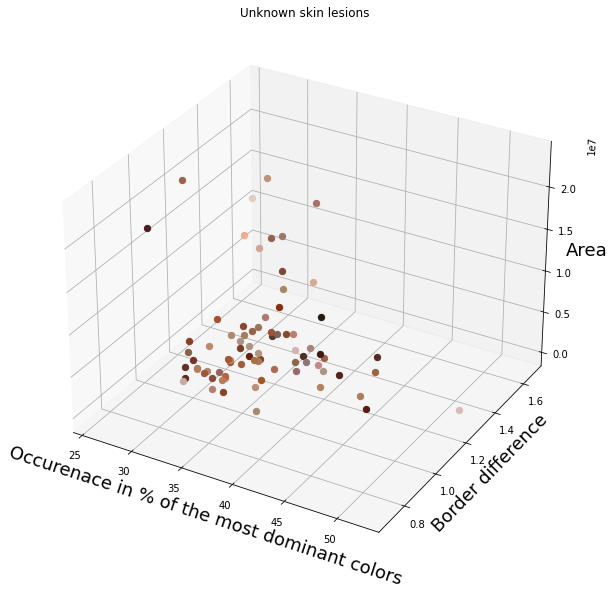

In [12]:
mask = final_df["help_int_for_colors"] == "healthy"
df = final_df[mask]
index = df.index

X = df["RGB4_occ"]
Y = df["border_diff_percent"]
Z = df["area"]
colors=df["RGB4html"]
#fig, ax = plt.subplots()
fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')

for i in index:
    ax.scatter(X[i], Y[i], Z[i], s = 40, color=colors[i])

ax.set_xlabel("Occurenace in % of the most dominant colors",fontsize=18)
ax.set_ylabel("Border difference",fontsize=18)
ax.set_zlabel("Area", fontsize = 18)
ax.set_title("Unknown## Area and perimeter scatterplot skin lesions")

plt.show()

<Figure size 720x720 with 0 Axes>

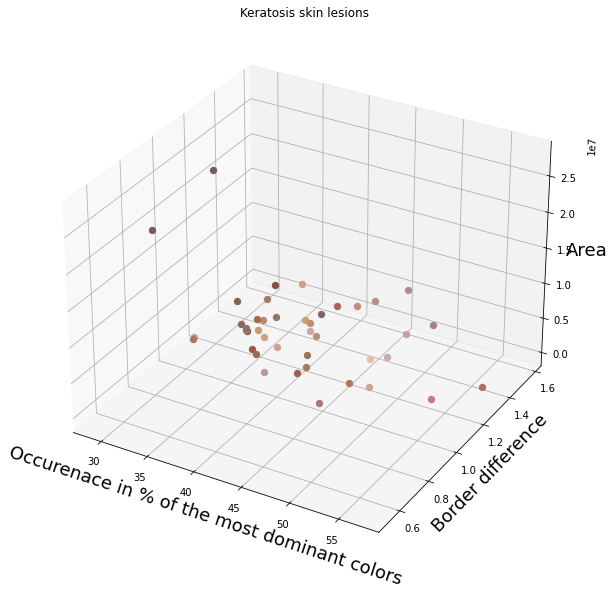

In [10]:
mask = final_df["help_int_for_colors"] == "keratosis"
df = final_df[mask]
index = df.index

X = df["RGB4_occ"]
Y = df["border_diff_percent"]
Z = df["area"]
colors=df["RGB4html"]
#fig, ax = plt.subplots()
fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')

for i in index:
    ax.scatter(X[i], Y[i], Z[i], s = 40, color=colors[i])

ax.set_xlabel("Occurenace in % of the most dominant colors",fontsize=18)
ax.set_ylabel("Border difference",fontsize=18)
ax.set_zlabel("Area", fontsize = 18)
ax.set_title("Keratosis skin lesions")

plt.show()

<Figure size 720x720 with 0 Axes>

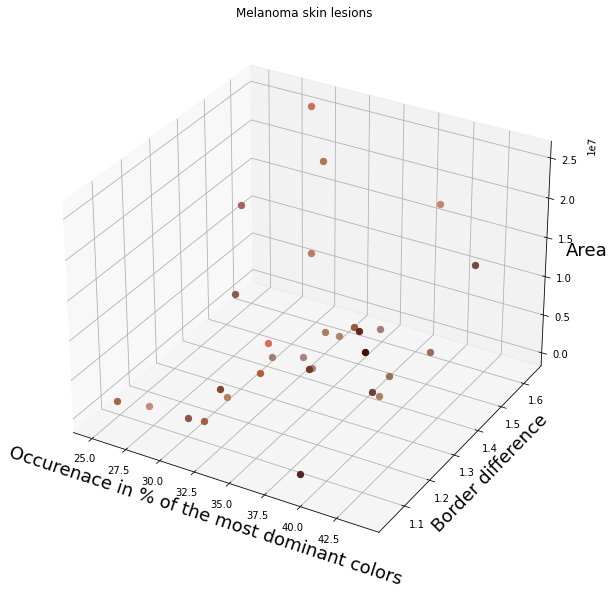

In [11]:
mask = final_df["help_int_for_colors"] == "melanoma"
df = final_df[mask]
index = df.index

X = df["RGB4_occ"]
Y = df["border_diff_percent"]
Z = df["area"]
colors=df["RGB4html"]
#fig, ax = plt.subplots()
fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')

for i in index:
    ax.scatter(X[i], Y[i], Z[i], s = 40, color=colors[i])

ax.set_xlabel("Occurenace in % of the most dominant colors",fontsize=18)
ax.set_ylabel("Border difference",fontsize=18)
ax.set_zlabel("Area", fontsize = 18)
ax.set_title("Melanoma skin lesions")

plt.show()